In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
print(tf.__version__)

import numpy as np
from Models import *
from Stacked_Model import *
from utils import *
from sklearn.model_selection import train_test_split

/home/yu.bryan.j/.pyenv/versions/tensorflow/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


2.2.0


Using TensorFlow backend.


##  Load the data
We consider the OMXS stock data, processed such that X reflects a given day's closing prices, a feature vector of 48 dimensions * lookback days, with the closing price of the stock if the stock was a constituent of the OMSX on a given date and 0 otherwsie.  Y is the lookahead classification denoted as 0 and 1 if the OMXS decreased or increased respectively.

The dataset considers dates in the range January 1, 2000 to March 3, 2020.

In [2]:
lookback = 10
lookahead = 20
EPOCHS = 100

X_train = np.load(f'../data/processed/OMXS_processed_forecast{lookahead}_train.npy')
y_train = np.load(f'../data/processed/OMXS_labels_forecast{lookahead}_train.npy')
X_test = np.load(f'../data/processed/OMXS_processed_forecast{lookahead}_test.npy')
y_test = np.load(f'../data/processed/OMXS_labels_forecast{lookahead}_test.npy')



X, Y = retrieve_lookback(X_train,y_train,lookback)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.20)

### We investigate the frequency of label occurance to determine if a balancing is required



Number of decreases: 1466, Number of Increases: 1913
Percentage of decreases: 0.4338561704646345
Percentage of increases: 0.5661438295353655


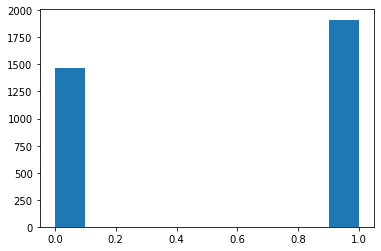

In [3]:
plt.hist(y_train)
uniques, counts = np.unique(y_train,return_counts=True)
print(f'Number of decreases: {counts[0]}, Number of Increases: {counts[1]}')
print(f'Percentage of decreases: {counts[0]/np.sum(counts)}')
print(f'Percentage of increases: {counts[1]/np.sum(counts)}')

Number of decreases: 367, Number of Increases: 478
Percentage of decreases: 0.43431952662721895
Percentage of increases: 0.565680473372781


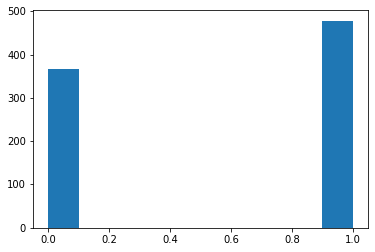

In [4]:
plt.hist(y_val)
uniques, counts = np.unique(y_val,return_counts=True)
print(f'Number of decreases: {counts[0]}, Number of Increases: {counts[1]}')
print(f'Percentage of decreases: {counts[0]/np.sum(counts)}')
print(f'Percentage of increases: {counts[1]/np.sum(counts)}')

####  MLP Results
As displayed, the MLP performs poorly in predicting the lookahead value of the index given the feature vector.  This result is not too surprising considering that the model has one hidden layer with 100 nodes.  Furthermore, the temporal nature of the dataset with shifts market sentiments would mean the underlying drivers behind price movements continues to change making learning difficult for the MLP

In [5]:
%%capture
mlp = MLP(100)
run_experiment(mlp, X_train, y_train, epochs = 50)

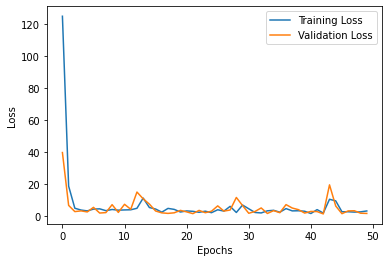

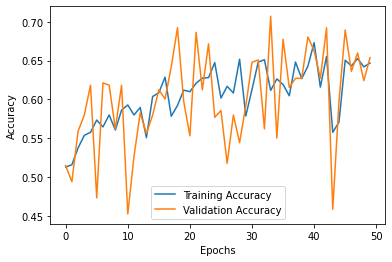

In [6]:
mlp.plot()

####  Test accuracy

In [7]:
mlp.get_accuracy(X_test,y_test)

0.6231060606060606

### Deep Feedforward Network

We extend the single hidden MLP into a deep network with three hidden layers, with batch normalization and  dropout after each hidden layer.  As shown below, the network begins to demonstrate some predictive powers but simulatneously unstable learning as shown in the spikes.

In [8]:
%%capture
model = Deep_MLP(100)
model.compile()
model.train(X_train,y_train,epochs=EPOCHS)

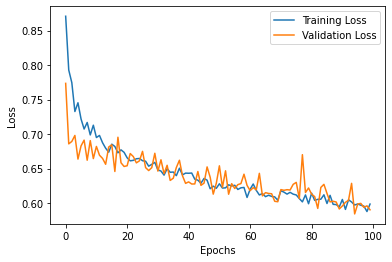

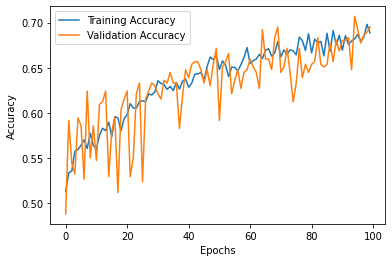

In [9]:
model.plot()

####  Test accuracy

In [10]:
model.get_accuracy(X_test,y_test)

0.696969696969697

### LSTM Results

Within the time series literature, LSTMs are reknown for their ability to deal with the vanishing/exploding gradient issue that arises due to taking gradients over time.  As such, LSTMS perform better in dealing with temporal sequences and this is reflected by the performance of the single layer LSTM network.

In [11]:
%%capture
lstm = LSTM_(100)
lstm.compile()
lstm.train(X_train,y_train,epochs=EPOCHS)

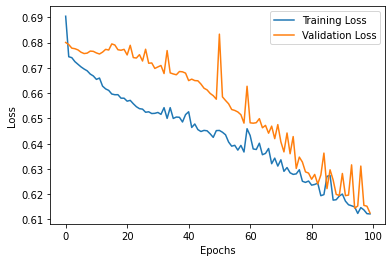

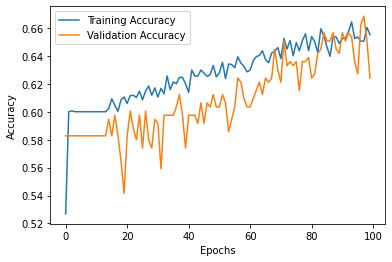

In [12]:
lstm.plot()

#### Test accuracy

In [13]:
lstm.get_accuracy(X_test,y_test)

0.6553030303030303

### CNN Results

We consider the traditional CNN network, one that has stacked layers of convolution and pooling, topped with a fully connected layer.  We note that the performance in predicting the lookahead value is poor with this network. We speculate a connection between the single layer MLP topping this network whose performance was poor as shown above - and as such, the convolution and max pooling serve as a dimensionality reduction process which proves sufficient to improve performance of an inapproriate network.

In [14]:
%%capture
cnn = CNN()
cnn.compile()
cnn.train(X_train,y_train, epochs=EPOCHS)

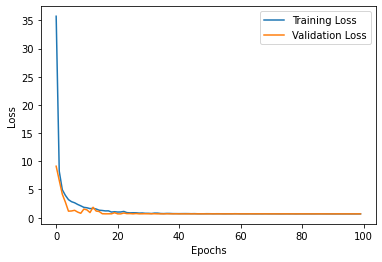

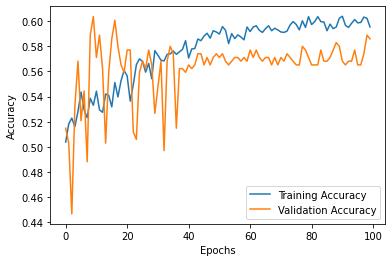

In [15]:
cnn.plot()

#### Test Accuracy

In [16]:
cnn.get_accuracy(X_test,y_test)

0.6070075757575758

### CNN LSTM Results

Proceding from the CNN results, as we believe the culprit was the MLP, we inserted an LSTM between the CNN and the MLP.  Immediately, we note the network predictive power improves.  Furthermore, the network's performance on the validation set improves as it continues with continued training.

In [17]:
%%capture
cnn_lstm = CNN_LSTM()
cnn_lstm.compile()
cnn_lstm.train(X_train,y_train, epochs=EPOCHS)


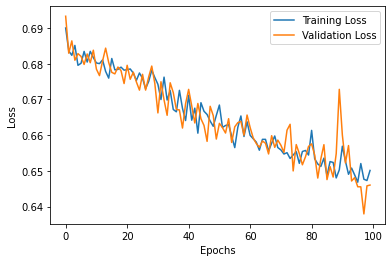

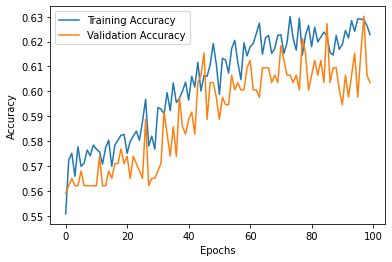

In [18]:
cnn_lstm.plot()

#### Test accuracy

In [19]:
cnn_lstm.get_accuracy(X_test,y_test)

0.6363636363636364

## Stacked Model

We introduce a novel model of stacked LSTM.  The input to the first LSTM is the price vector.  The input to the second LSTM is a stream of price movements as generated from the GAN.  That is, for our lookforward period, we apply the gan to create a price trajectory based on the learned joint distribution which represents a personalized prediction of the future.

In [12]:
%%capture
experimental = gan_experiment(X_train, y_train, X_val, y_val, lookahead, gan_epochs=50, SM_epochs=50)

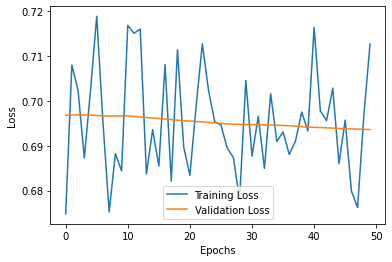

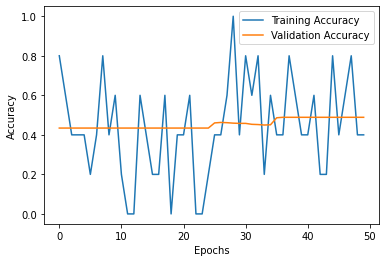

In [13]:
experimental.plot()

#### Test accuracy

In [14]:
experimental.get_accuracy(X_test,y_test, lookahead)

0.5142045454545454